## Распознавание карт лояльности на Keras

1. Работаем с датасетом карт лояльности. Задача: по фотографии классифицировать к какому бренду относится карточка. Всего 18 классов. 
2. Объявим и обучим модель, классифицирующую карточки
3. Посмотрим как объявлять и использовать кастомные метрики 
4. Посмотрим что такое Callbacks
5. Сделаем для нашей модели Callback-tqdm, Callback для сохранения модели и Callback для Tensorboard
6. Чуть подробнее поговорим про Tensorboard

In [28]:
# Сначала сделаем загрузку данных:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/DmitriiDenisov/intro_dl_seminars/master/setup_colab.py -O setup_google_colab.py
from setup_google_colab import setup_week2
setup_week2()

--2019-03-19 15:33:40--  https://raw.githubusercontent.com/DmitriiDenisov/intro_dl_seminars/master/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1109 (1.1K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.08K  --.-KB/s    in 0s      

2019-03-19 15:33:40 (194 MB/s) - ‘setup_google_colab.py’ saved [1109/1109]

week2
/content


data.zip: 100%|██████████| 49.1M/49.1M [00:02<00:00, 24.8MB/s]


 В этом ноутбуке будем работать с датасетом карт лояльности. 
 Задача: по фотографии карточки определить к какому бренду она относится

В данном ноутбуке мы разберём пример практической задачи по распазнованию бренда карты лояльности по её фотографии.

In [0]:
from numpy.random import choice
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [0]:
PROJECT_PATH = os.getcwd()
PATH_TRAIN = os.path.join(PROJECT_PATH, 'data', 'TEMP_CODE', 'train')

In [0]:
all_files = []
for root, dirs, files in os.walk(PATH_TRAIN):
    for f in files:
        all_files.append( os.path.abspath(os.path.join(root, f)).replace("\\","/"))

Ниже приведён пример данных, на которых мы будем обучаться:

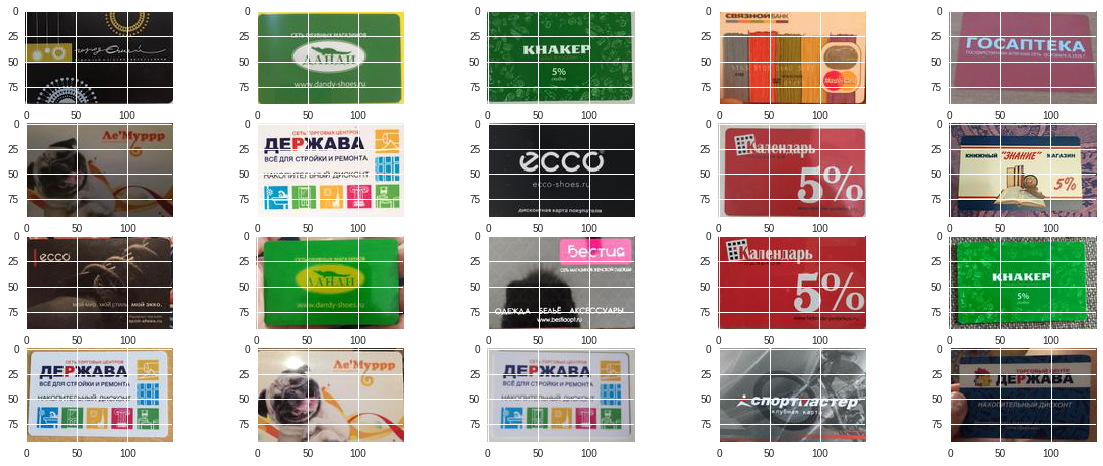

In [32]:
SIZE = 20 # число случайно выбранных карточек из обучающего датасета
selected = choice(all_files, size=SIZE)

images = []
for img_path in selected:
    #print(img_path)
    images.append(mpimg.imread(img_path))
#print(images)

plt.figure(figsize=(20,10))
columns = 5
for i, image_ in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image_)

Всего в выборке 18 классов, в каждом примерно по 200 фотографий, итого примерно 3600 фотографий в обучающей выборке. В валидационной выборке те же 18 классов, для ккаждого примерно по 30 фотографий, итого 540 фотографий в валидационной выборке

In [0]:
import os
import sys
import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.core import Activation, Reshape, Dense, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint
#from keras.layers import DepthwiseConv2D
#from keras.applications.mobilenet import relu6
from keras.utils.generic_utils import CustomObjectScope
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
PROJECT_PATH = os.getcwd()
sys.path.append(PROJECT_PATH)

def count_folders(path):
    return len(glob.glob(os.path.join(path,'*')))

def get_barcode_class(path):
    return os.path.basename(path)

### Объявления:

Вспомогательные объявления, например, число классов, размер батча, путь к данным и т.д.

In [0]:
args = {'batch_size': 16, 'data_path': os.path.join(PROJECT_PATH, 'data', 'TEMP_CODE'), 
        'previous_model': ''}

""" Define barcode class and underlying classes number from file structure """
NUM_CLASSES = count_folders(os.path.join(args['data_path'], 'train'))
BARCODE = get_barcode_class(args['data_path'])
SUPPORT_FILES_PATH = os.path.join(PROJECT_PATH, 'resource', BARCODE, 'support_files')
""" Define data path and output path  """
DATA_PATH = args['data_path']

""" Check if previously trained model is used """
if args['previous_model'] == '':
    TRAIN_FROM_ZERO = True
else:
    TRAIN_FROM_ZERO = False

### Модель:

Ниже следует блок с объявлением модели. Вы можете: 

1) Собрать кастомную сеть

2) Загрузить существующую сеть. Например, для импорта VGG16: ```from keras.applications import vgg16```, затем ```model = vgg16.VGG16(weights='imagenet')```. У модели можно зафиксировать веса первых n слоёв и обучать все оставшиеся

3) Загрузить модель из папки models и дообучить её. При первом запуске папка models пустая, в неё будут автоматически сохраняться модели при обучении в конце каждой эпохи

In [0]:
from keras.layers import Dropout

In [38]:
###

model = Sequential()
model.add(InputLayer((93, 146, 3)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(18, activation='softmax'))


model.summary()
# <YOUR CODE GOES HERE>
# Здесь объявите свою модель
# В случае, если вы захотите загружать существующую модель из Кераса, то для того, чтобы поменять последние слои
# вам понадобятся следующие команды:
#model.layers.pop()
#model.layers[-1].output
#Model(input=model.inputs, output=x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 89, 142, 16)       1216      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 140, 32)       4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 44, 70, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 70, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 42, 68, 32)        9248      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 66, 64)        18496     
___________________________

In [39]:
OUTPUT_PATH = os.path.join(PROJECT_PATH, 'models')
os.makedirs(OUTPUT_PATH)

FileExistsError: ignored

### Объявления генераторов данных:

Ниже объявим генераторы данных.
В Керасе реализован класс ImageDataGenerator, который определяет конфигурацию для подготовленных к обучению изображений, а также отвечает за аугментацию данных.
Аугументация данных происходит на лету во время обучения раз в эпоху, поэтому данные почти никогда не будут повторяться - это хорошо. И точка переобучения будет дальше - можно тренировать больше эпох.

Краткий туторила по генераторам данных из Keras: 
https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

Параметры объекта ```keras.preprocessing.image.ImageDataGenerator```: https://keras.io/preprocessing/image/

In [40]:
os.path.join(args['data_path'], 'train')

'/content/data/TEMP_CODE/train'

In [42]:
args['batch_size']

16

In [43]:
""" Data generators initialization: for train and validation sets """
train_datagen = image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=False)

train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(args['data_path'], 'train'),
    target_size=images[0].shape[:2],
    color_mode="rgb",
    batch_size=args['batch_size'],
    class_mode="categorical",
    shuffle=True,
    seed=42
)

valid_datagen = image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=0)

valid_generator = valid_datagen.flow_from_directory(
    directory=os.path.join(args['data_path'], 'val'),
    target_size=images[0].shape[:2],
    color_mode="rgb",
    batch_size=args['batch_size'],
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 4520 images belonging to 18 classes.
Found 2256 images belonging to 18 classes.


Делаем compile и запускаем обучение:

In [0]:
""" Set train parameters for choosen model """
# Можете расккоментировать другие оптимизаторы:
#sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#optimize = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

STEP_SIZE_TRAIN = (train_generator.n // train_generator.batch_size)
STEP_SIZE_VALID = (valid_generator.n // valid_generator.batch_size)

### Обучение модели:

В модель передаём: генератор данных (он сам автоматически генерирует X и y), валидационную выборку (тоже посредством генератора), число эпох, коллбеки и verbose

In [45]:
""" Training """
history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=valid_generator,
                                  validation_steps=STEP_SIZE_VALID,
                                  epochs=1,
                                  verbose=1
                                  )

Epoch 1/1
282/282 [==============================] - 33s 116ms/step - loss: 1.4956 - acc: 0.5541 - val_loss: 0.4003 - val_acc: 0.8994


__Вопрос__: почему последняя итерация в эпохе идет с небольшой задержкой?

## Кастомные метрики:

In [0]:
import keras.backend as K

def precision(y_true, y_pred):
    """Precision metric.
     Only computes a batch-wise average of precision.
     Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.
     Only computes a batch-wise average of recall.
     Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', precision, recall])

In [48]:
#from keras_tqdm import TQDMNotebookCallback

history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=valid_generator,
                                  validation_steps=STEP_SIZE_VALID,
                                  epochs=1,
                                  verbose=1
                                  #callbacks=[TQDMNotebookCallback(leave_inner=True)]
                                  )

Epoch 1/1
282/282 [==============================] - 32s 115ms/step - loss: 0.4156 - acc: 0.8905 - precision: 0.9402 - recall: 0.8595 - val_loss: 0.2461 - val_acc: 0.9371 - val_precision: 0.9657 - val_recall: 0.9136


## CallBacks:

__Коллбеки__: это класс, имеющий набор методов on_train_begin, on_train_end, on_epoch_begin, on_epoch_end, on_batch_begin, on_batch_end, которые позволяют выполнять какой-либо код в конце эпохи, в начале эпохи, в конце батча, в начале батча, в конце обучения, в начале обучения

Примеры применения: 
 - Сохранение метрик качества в процессе обучения для онлайн визуализации
 - Отправление в телегреамм/почту метрик качества
 - Сохранение модели в конце каждой эпохи (можно даже после каждого батча)

Примеры реализованных в Керасе коллбеков:

 - EarlyStopping - делает раннюю остановку процесса обучения по некоторому критерию (например, лосс не падает n эпох)

 - ModelCheckpoint - сохраняет модель после каждой эпохи

 - RemoteMonitor - отправляет логи на сервер

 - TensorBoard - сохраняет логи в папки для последующей визуализации в TensorBoard

In [49]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

""" Callbacks """
checkpointer = ModelCheckpoint('models/weights.{epoch:02d}-val_loss{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

""" Enable logging for Tensorboard """

# Скоращает learning rate, когда loss не уменьшается несколько эпох подряд:
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, min_lr=0)

# Останавливает обучение по какому либо критерию. Например, loss не уменьшается 3 эпохи подряд
early_stop = EarlyStopping(monitor='val_loss', patience=3)

tqdm = TQDMNotebookCallback(leave_inner=True)


model.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=valid_generator,
                                  validation_steps=STEP_SIZE_VALID,
                                  epochs=1,
                                  verbose=2,
                                  callbacks=[checkpointer, reduce, early_stop, tqdm]
                                  )

Epoch 1/1


 - 33s - loss: 0.2846 - acc: 0.9255 - precision: 0.9545 - recall: 0.9056 - val_loss: 0.2296 - val_acc: 0.9410 - val_precision: 0.9642 - val_recall: 0.9260

Epoch 00001: val_loss improved from inf to 0.22964, saving model to models/weights.01-val_loss0.23.hdf5


Шаблон для своего коллбека:

In [0]:
class My_Callback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return

### Чуть подробнее остановимся на Callback'е TensorBoard:

In [50]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab() # генерирует URL
# В fit же передайте объект TensorBoardColabCallback(tbc)

Wait for 8 seconds...
TensorBoard link:
https://18d3a000.ngrok.io


In [51]:
model.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=valid_generator,
                                  validation_steps=STEP_SIZE_VALID,
                                  epochs=5,
                                  verbose=2,
                                  callbacks=[TensorBoardColabCallback(tbc), tqdm]
                                  )

Epoch 1/5


 - 32s - loss: 0.2187 - acc: 0.9437 - precision: 0.9643 - recall: 0.9253 - val_loss: 0.3118 - val_acc: 0.9291 - val_precision: 0.9507 - val_recall: 0.9158
Epoch 2/5


 - 31s - loss: 0.1885 - acc: 0.9484 - precision: 0.9675 - recall: 0.9340 - val_loss: 0.2269 - val_acc: 0.9428 - val_precision: 0.9636 - val_recall: 0.9300
Epoch 3/5


 - 30s - loss: 0.1633 - acc: 0.9563 - precision: 0.9704 - recall: 0.9404 - val_loss: 0.1427 - val_acc: 0.9601 - val_precision: 0.9754 - val_recall: 0.9521
Epoch 4/5


 - 32s - loss: 0.1505 - acc: 0.9583 - precision: 0.9711 - recall: 0.9473 - val_loss: 0.1679 - val_acc: 0.9570 - val_precision: 0.9712 - val_recall: 0.9464
Epoch 5/5


 - 31s - loss: 0.1294 - acc: 0.9641 - precision: 0.9765 - recall: 0.9541 - val_loss: 0.1553 - val_acc: 0.9614 - val_precision: 0.9730 - val_recall: 0.9548


Если не открывается URL, то нужно включить VPN. Например, через opera vpn или установить на Chrome расширение (например, Browsec https://chrome.google.com/webstore/detail/browsec-vpn-free-and-unli/omghfjlpggmjjaagoclmmobgdodcjboh)